In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

In [5]:
#load the data set
df = pd.read_csv("./stroke_risk_dataset.csv")

In [7]:
def get_basic_info(df):
    """Get basic information about the dataset"""
    print(f"Number of Rows: {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Columns : {df.columns.tolist()}")
    print(f"Columns Data Types:\n{df.dtypes}")
    print(f"Missing Values: {df.isnull().sum().sum()}")
    print(f"Missing Values (Per Column):\n{df.isnull().sum()}")
    print(f"Missing Values (Per Column Percentage):\n{(df.isnull().mean() * 100)}")
    print(f"Unique Values (Per Column):\n{df.nunique()}")

In [9]:
get_basic_info(df)

Number of Rows: 70000
Number of Columns: 18
Columns : ['Chest Pain', 'Shortness of Breath', 'Irregular Heartbeat', 'Fatigue & Weakness', 'Dizziness', 'Swelling (Edema)', 'Pain in Neck/Jaw/Shoulder/Back', 'Excessive Sweating', 'Persistent Cough', 'Nausea/Vomiting', 'High Blood Pressure', 'Chest Discomfort (Activity)', 'Cold Hands/Feet', 'Snoring/Sleep Apnea', 'Anxiety/Feeling of Doom', 'Age', 'Stroke Risk (%)', 'At Risk (Binary)']
Columns Data Types:
Chest Pain                          int64
Shortness of Breath                 int64
Irregular Heartbeat                 int64
Fatigue & Weakness                  int64
Dizziness                           int64
Swelling (Edema)                    int64
Pain in Neck/Jaw/Shoulder/Back      int64
Excessive Sweating                  int64
Persistent Cough                    int64
Nausea/Vomiting                     int64
High Blood Pressure                 int64
Chest Discomfort (Activity)         int64
Cold Hands/Feet                     int64



# ===== 📊 Visualizations =====

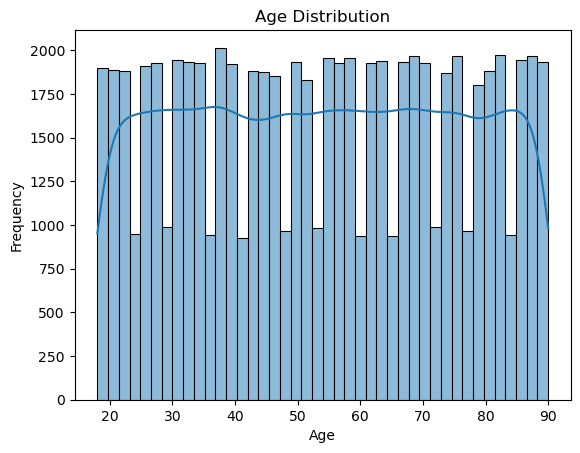

In [11]:
# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

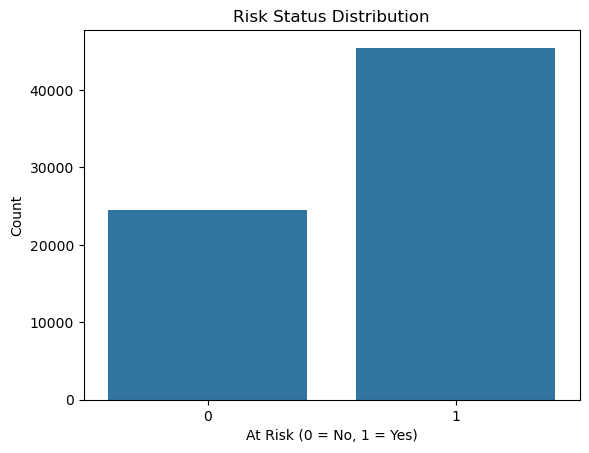

In [13]:
# Target distribution
sns.countplot(x=df['At Risk (Binary)'])
plt.title('Risk Status Distribution')
plt.xlabel('At Risk (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

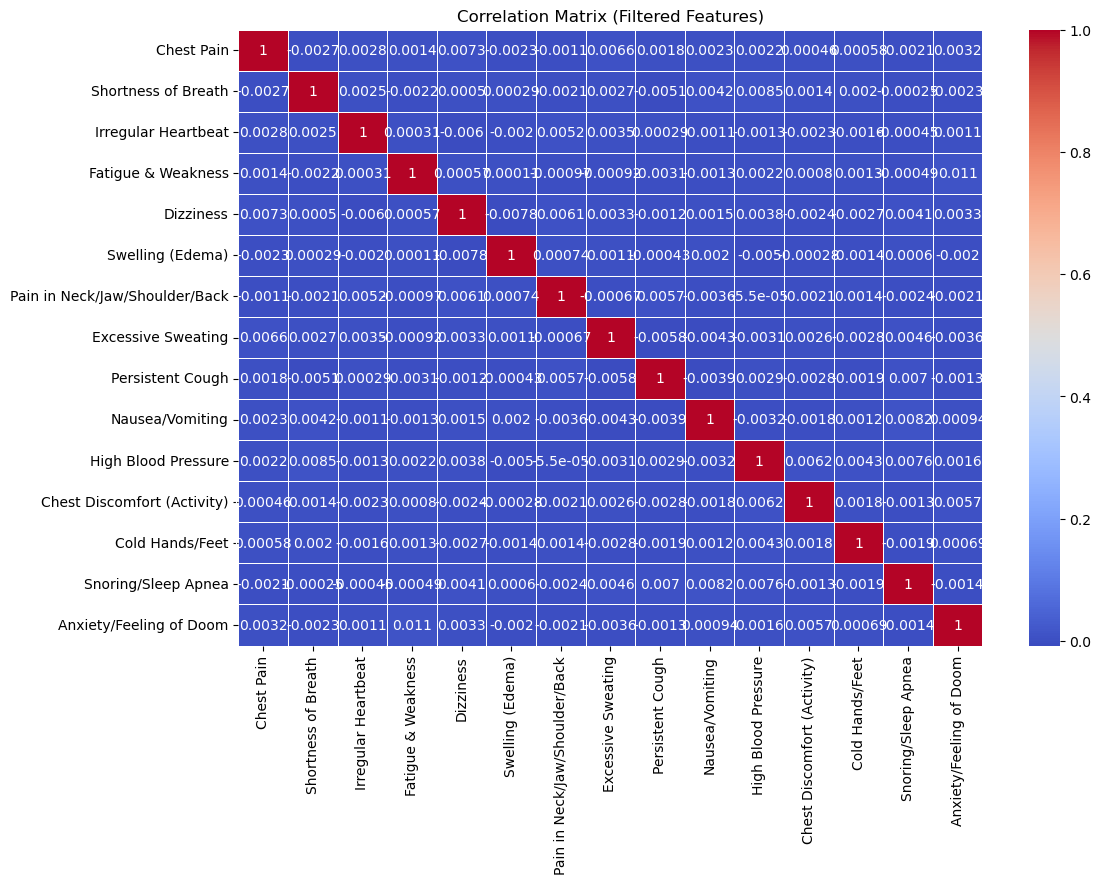

In [15]:
# Correlation matrix (excluding non-numeric & target columns)
excluded_columns = ['Age', 'At Risk (Binary)', 'Stroke Risk (%)']
df_filtered = df.drop(columns=excluded_columns, errors='ignore')

plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Filtered Features)')
plt.show()

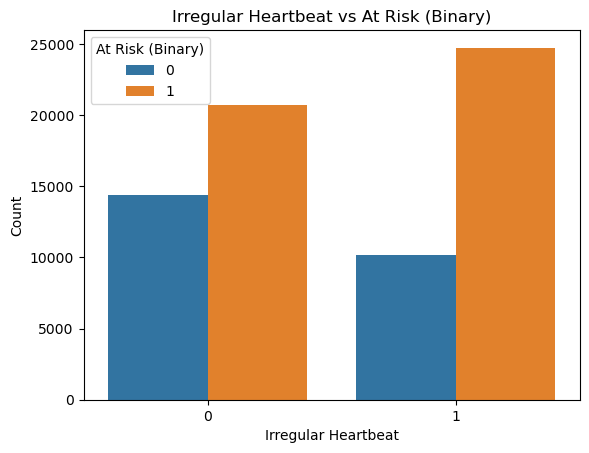

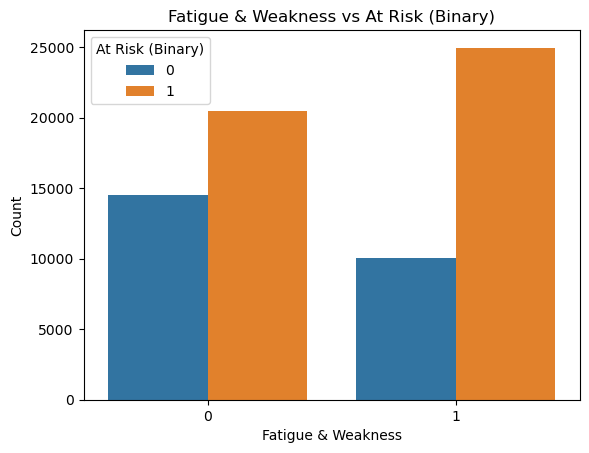

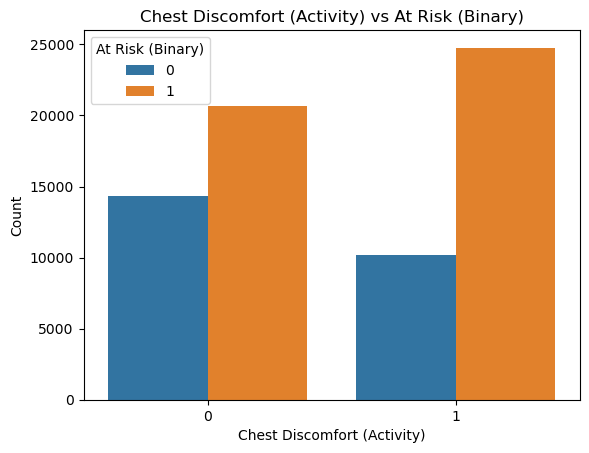

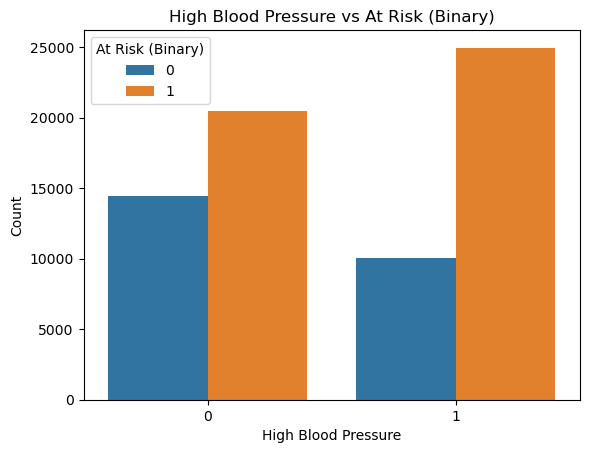

In [17]:
# Selected features vs target
cols = ['Irregular Heartbeat', 'Fatigue & Weakness', 'Chest Discomfort (Activity)', 'High Blood Pressure']
for col in cols:
    sns.countplot(x=col, hue='At Risk (Binary)', data=df)
    plt.title(f'{col} vs At Risk (Binary)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

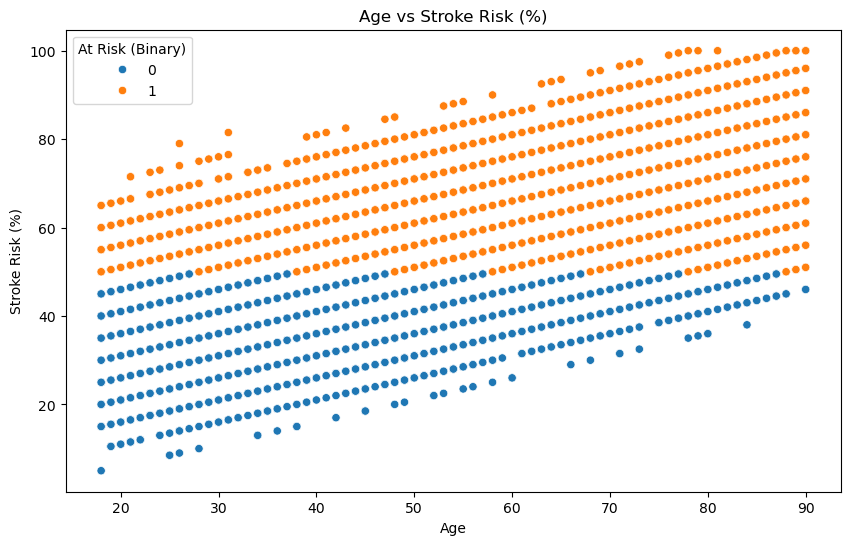

In [19]:
# Scatter plot: Age vs Stroke Risk (%)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Stroke Risk (%)', hue='At Risk (Binary)', data=df)
plt.title('Age vs Stroke Risk (%)')
plt.xlabel('Age')
plt.ylabel('Stroke Risk (%)')
plt.show()

# ===== 🧹 Data Preprocessing =====

In [21]:
# 1. Remove duplicates
df.drop_duplicates(inplace=True)

In [23]:
# 2. Drop columns that leak or aren't available in prediction phase
df.drop(columns=['Stroke Risk (%)'], inplace=True)

In [25]:
# 3. Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [27]:
# 4. Encode categorical variables using LabelEncoder
label_encoders = {}
for col in df_imputed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])
    label_encoders[col] = le  # save encoder in case needed for inverse transform

In [29]:
# 5. Separate features and target variable
X = df_imputed.drop(columns=['At Risk (Binary)'])
y = df_imputed['At Risk (Binary)']

In [31]:
# 6. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===== 🤖 Model Training =====

In [37]:
model = GradientBoostingClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=300, random_state=42)

# ===== 📈 Model Evaluation =====

In [38]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 99.37%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4783
           1       0.99      1.00      1.00      9013

    accuracy                           0.99     13796
   macro avg       1.00      0.99      0.99     13796
weighted avg       0.99      0.99      0.99     13796



# ===== 🔲 Confusion Matrix=====

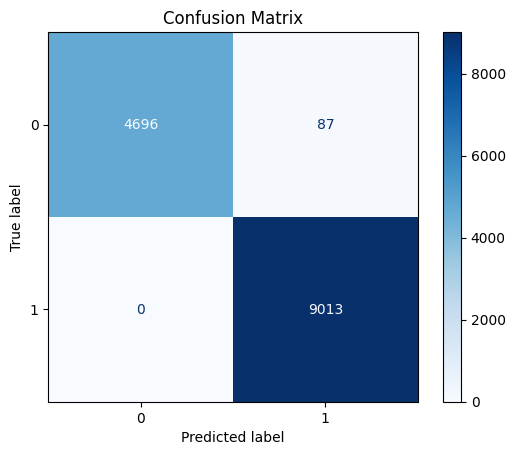

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ===== 🧪 ROC Curve =====

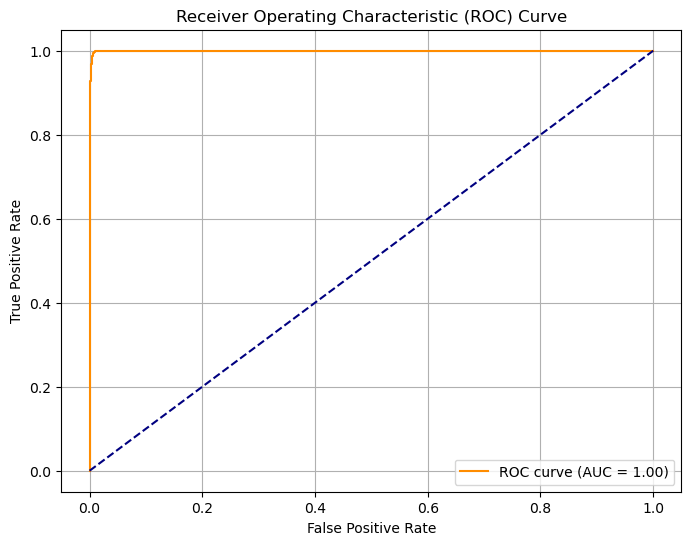

In [39]:
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ===== 🔍 Feature Importance =====

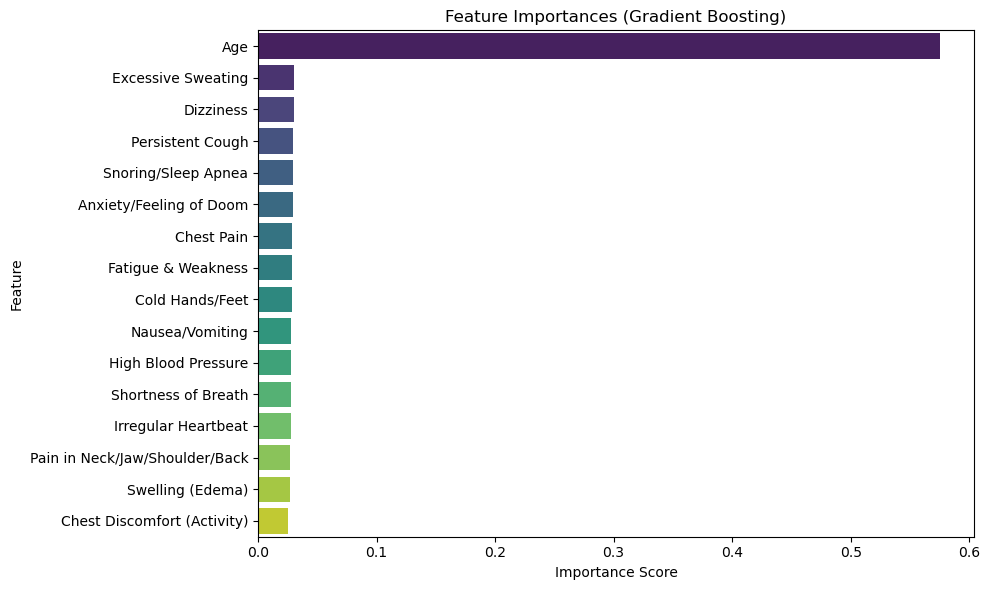

In [48]:
importances = model.feature_importances_
features = X.columns

# Create a sorted feature importance chart
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Feature Importances (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
